In [2]:
import numpy as np
import torch
from torch import FloatTensor,Tensor,LongTensor
from Policy import REINFORCE, ActorCritic
import gym
import random
import matplotlib.pyplot as plt
import time

In [8]:
a = [4,500,500]

b = np.full(10,500)
np.concatenate((a,b))

array([  4, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500])

# REINFORCE
We define a function to run REINFORCE algorithm on.

In [3]:
def Cartpole(total_episodes, learning_rate, future_reward_discount_factor, hidden_shape):
    """
    Tries to solve Cartpole-v1 usinf the REINFORCE algorithm. Right now it only applies a Monte-Carlo REINFORCE

    Args:
        total_episodes: How many times the environment resets
        learning_rate: For optimizer
        future_reward_discount_factor: future rewards are dicounted
        hidden_shape: List of integers. [16,16] would give two hidden layers (linear with PReLU activation) with both 16 nodes in the policy model
    
    Returns:
        scores: Score per episode in a list
    """
    
    
    scores = []
    env = gym.make("CartPole-v1")
    agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, learning_rate, future_reward_discount_factor, hidden_shape)

    for i in range(total_episodes):
        #reset the environment
        state = env.reset()
        rewards = []
        log_probs = []

        #Cartpole-v1 has a maximum episode length of 500
        for t in range(500):
            #env.render()
            #Action selection is done by the policy
            action, log_prob = agent.model.pick(state)

            #Get example
            state, reward, done, _ = env.step(action)

            rewards.append(reward)
            log_probs.append(log_prob)

            #The score is how long the cart stayed upright, this can be a maximum of 500
            if done or t==499:
                print(f"Episode {i}: Score {t+1}/500")
                break
        
        rewards = torch.tensor(rewards)
        log_probs = torch.cat(log_probs)
        agent.update(rewards,log_probs)

        scores.append(t+1)

        #Cartpole v1 is considered solved when
        # the average over the last 100 consecutive episodes is at least 475
        if np.mean(scores[-100:]) >= 475: 
            mask = np.full(total_episodes - (i + 1),500)
            scores = np.concatenate((scores,mask))
            print("Solved!")
            break

    if np.mean(scores[-100:]) < 475: 
        print("Not Solved...")
    return scores

    

Trying it out

In [4]:
#Parameters
total_episodes = 1000
learning_rate = 1e-2
future_reward_discount_factor = 1
hidden_shape = [32]

score = Cartpole(total_episodes, learning_rate, future_reward_discount_factor, hidden_shape)

Episode 0: Score 9/500
Episode 1: Score 9/500
Episode 2: Score 10/500
Episode 3: Score 22/500
Episode 4: Score 11/500
Episode 5: Score 11/500
Episode 6: Score 12/500
Episode 7: Score 42/500
Episode 8: Score 13/500
Episode 9: Score 22/500
Episode 10: Score 34/500
Episode 11: Score 18/500
Episode 12: Score 25/500
Episode 13: Score 19/500
Episode 14: Score 11/500
Episode 15: Score 21/500
Episode 16: Score 46/500
Episode 17: Score 11/500
Episode 18: Score 18/500
Episode 19: Score 12/500
Episode 20: Score 22/500
Episode 21: Score 12/500
Episode 22: Score 15/500
Episode 23: Score 69/500
Episode 24: Score 16/500
Episode 25: Score 21/500
Episode 26: Score 16/500
Episode 27: Score 24/500
Episode 28: Score 35/500
Episode 29: Score 25/500
Episode 30: Score 76/500
Episode 31: Score 50/500
Episode 32: Score 23/500
Episode 33: Score 17/500
Episode 34: Score 28/500
Episode 35: Score 50/500
Episode 36: Score 36/500
Episode 37: Score 33/500
Episode 38: Score 126/500
Episode 39: Score 47/500
Episode 40:

Text(0, 0.5, 'Score')

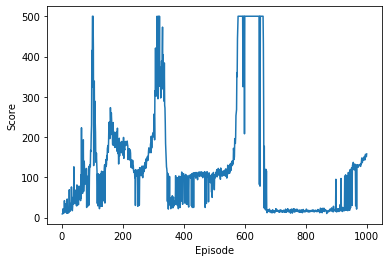

In [5]:
#Plot score per episode
plt.plot(np.arange(1,total_episodes+1), score)
plt.xlabel("Episode")
plt.ylabel("Score")

# Actor-Critic

In [25]:
def AC(total_episodes, estimation_depth, learning_rate, gradient_method, hidden_shape_actor, hidden_shape_critic):
    """
    Tries to solve Cartpole-v1 usinf the REINFORCE algorithm. Right now it only applies a Monte-Carlo REINFORCE

    Args:
        total_episodes: How many times the environment resets
        learning_rate: For optimizer
        future_reward_discount_factor: future rewards are dicounted
        hidden_shape: List of integers. [16,16] would give two hidden layers (linear with PReLU activation) with both 16 nodes in the policy model
    
    Returns:
        scores: Score per episode in a list
    """
    
    
    scores = []
    env = gym.make("CartPole-v1")
    agent = ActorCritic(env.observation_space.shape[0], env.action_space.n, estimation_depth, gradient_method, learning_rate, hidden_shape_actor, hidden_shape_critic)
    counter = 0

    for i in range(total_episodes):
        #reset the environment
        state = env.reset()
        rewards = []
        log_probs = []
        states = []

        #Cartpole-v1 has a maximum episode length of 500
        for t in range(500):
            #env.render()
            states.append(state)

            #Action selection is done by the policy
            action, log_prob = agent.actor.pick(state)

            #Get example
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)

            #The score is how long the cart stayed upright, this can be a maximum of 500
            if done or t==499:
                print(f"Episode {i}: Score {t+1}/500")
                break

        states = torch.Tensor(np.array(states))
        rewards = np.array(rewards)
        log_probs = torch.cat(log_probs)
        agent.update(rewards,log_probs, states)

        scores.append(t+1)
        #Cartpole v1 is considered solved when
        # the average over the last 100 consecutive episodes is at least 475
        if np.mean(scores[-100:]) >= 475: 
            mask = np.full(total_episodes - (i + 1),500)
            scores = np.concatenate((scores,mask))
            print("Solved!")
            break
    if np.mean(scores[-100:]) < 475: 
        print("Not Solved...")
    return scores

    

In [26]:
#Parameters
total_episodes = 1000
learning_rate = 1e-2
estimation_depth = 500
gradient_method = 'nstep'
hidden_shape_actor = [16]
hidden_shape_critic = [16]

score = AC(total_episodes, estimation_depth, learning_rate, gradient_method, hidden_shape_actor, hidden_shape_critic)

Episode 0: Score 17/500
Episode 1: Score 11/500
Episode 2: Score 21/500
Episode 3: Score 10/500
Episode 4: Score 58/500
Episode 5: Score 10/500
Episode 6: Score 61/500
Episode 7: Score 11/500
Episode 8: Score 23/500
Episode 9: Score 24/500
Episode 10: Score 17/500
Episode 11: Score 18/500
Episode 12: Score 33/500
Episode 13: Score 27/500
Episode 14: Score 21/500
Episode 15: Score 27/500
Episode 16: Score 13/500
Episode 17: Score 21/500
Episode 18: Score 20/500
Episode 19: Score 17/500
Episode 20: Score 30/500
Episode 21: Score 29/500
Episode 22: Score 18/500
Episode 23: Score 17/500
Episode 24: Score 14/500
Episode 25: Score 28/500
Episode 26: Score 24/500
Episode 27: Score 46/500
Episode 28: Score 25/500
Episode 29: Score 32/500
Episode 30: Score 19/500
Episode 31: Score 19/500
Episode 32: Score 19/500
Episode 33: Score 24/500
Episode 34: Score 14/500
Episode 35: Score 17/500
Episode 36: Score 103/500
Episode 37: Score 59/500
Episode 38: Score 37/500
Episode 39: Score 15/500
Episode 4

Text(0, 0.5, 'Score')

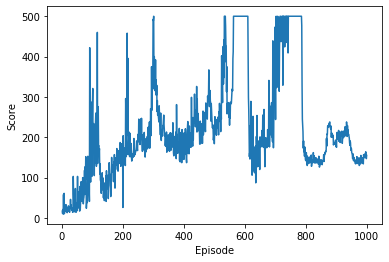

In [27]:
#Plot score per episode
plt.plot(np.arange(1,total_episodes+1), score)
plt.xlabel("Episode")
plt.ylabel("Score")